# Project 4 : West-Nile-Virus-Prediction

### Contents:
- [Background](#Background)
- [Data Import & Cleaning](#Data-Import-and-Cleaning)
- [Further Data Cleaning](#Further-Data-Cleaning)
- [EDA](#EDA)
- [Feature Engineering](#Feature-Engineering)
- [Data Preparation](#Data-Preparation)
- [Modelling](#Modelling)
- [Submission](#Submission)

# Import Libraries

In [41]:
# Imports:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler
from sklearn.inspection import partial_dependence,PartialDependenceDisplay

from sklearn import metrics
from sklearn.metrics import f1_score,confusion_matrix, plot_confusion_matrix,ConfusionMatrixDisplay,accuracy_score, RocCurveDisplay, roc_auc_score

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler 

from sklearn.cluster import KMeans

import lightgbm as lgb

import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

get_ipython().run_line_magic('matplotlib', 'inline')

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import geopandas as gpd

import datetime

In [42]:
#steps to install geopandas


#!pip install pipwin
#!pipwin install gdal
#!pipwin install fiona
#!pip install geopandas
#!pipwin install rasterio
#pip install contextily

In [43]:
#!pip install imblearn

In [44]:
#!pip install lightgbm

# define some functions

In [45]:
#the fuction will 
#1. plot neighborhoods map of chicago
#2. plot 2 weather stations on the map
#3. based on the input parameters,
#   a. convert the input dataframe into geopandas dataframe
#   b. plot the dataframe on the chicago map. 
#   c. if the dataframe contain column 'NumMosquitos', the function will adjust the markersize according to 'NumMosquitos'
def plot_geodata(dict_df   # dictionary containing dataframe and its name  
                ):
    colors = ['black','orange','red','yellow']
    markersizes = [3,1, 14,  5]
    zorders = [4,1,3,2]
    
    fig_, ax_ = plt.subplots(figsize=(20,20))
    
    #plot neighborhoods map of chicago
    geojson_file = '../assets/Boundaries_Community_Areas.geojson'
    neighborhoods = gpd.read_file(geojson_file)
    neighborhoods.plot(ax=ax_)
    
    #plot station
    # initialize list of lists
    list_station = [['1',  41.995,-87.933], ['2', 41.786,-87.752]]
    df_station = pd.DataFrame(list_station, columns=['Station', 'Latitude','Longitude'])
    gdf = gpd.GeoDataFrame(df_station, geometry=gpd.points_from_xy(df_station.Longitude, df_station.Latitude))
    gdf.plot(ax=ax_, color='purple', markersize=20,zorder=5, label="weather stations")
    
    #plot input dataframes
    i=0
    for label_df,df in dict_df.items():
        color_ = colors[i]
        
        #if the dataframe has column 'NumMosquitos', the markersize will be adjusted according to this column
        if 'NumMosquitos' in df.columns:
            markersize_ = df['NumMosquitos']
        else:
            markersize_ = markersizes[i]
        zorder_ = zorders[i]
        label_ = label_df

        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
        gdf.plot(ax=ax_, color=color_, markersize=markersize_,zorder=zorder_, label=label_)
        i += 1
        
    ax_.legend(loc='center left', fontsize=12, markerscale=5)
    plt.show()
    return 

# import data from pickle file

In [46]:
#read pickle_dict, which store everything
pickle_dict1 = pickle.load(open('../assets/data1.pkl', 'rb'))
df_train = pickle_dict1['df_train']
df_test = pickle_dict1['df_test']
df_spray = pickle_dict1['df_spray']
df_weather_1 = pickle_dict1['df_weather_1']
df_weather_2 = pickle_dict1['df_weather_2']

In [47]:
df_spray['Date'].unique()

array(['2011-09-07T00:00:00.000000000', '2013-07-17T00:00:00.000000000',
       '2013-07-25T00:00:00.000000000', '2013-08-08T00:00:00.000000000',
       '2013-08-15T00:00:00.000000000', '2013-08-16T00:00:00.000000000',
       '2013-08-22T00:00:00.000000000', '2013-08-29T00:00:00.000000000',
       '2013-09-05T00:00:00.000000000'], dtype='datetime64[ns]')

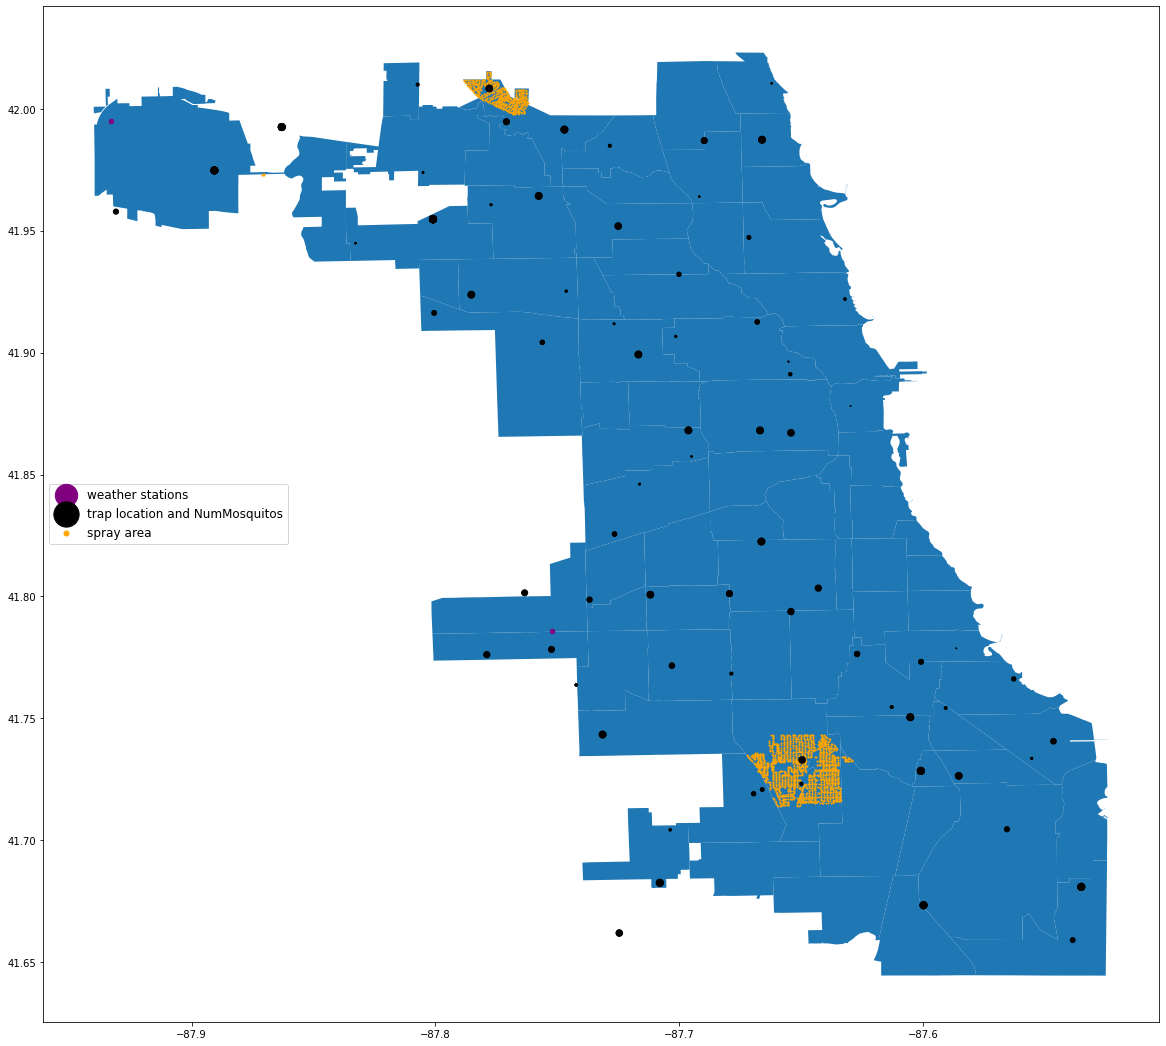

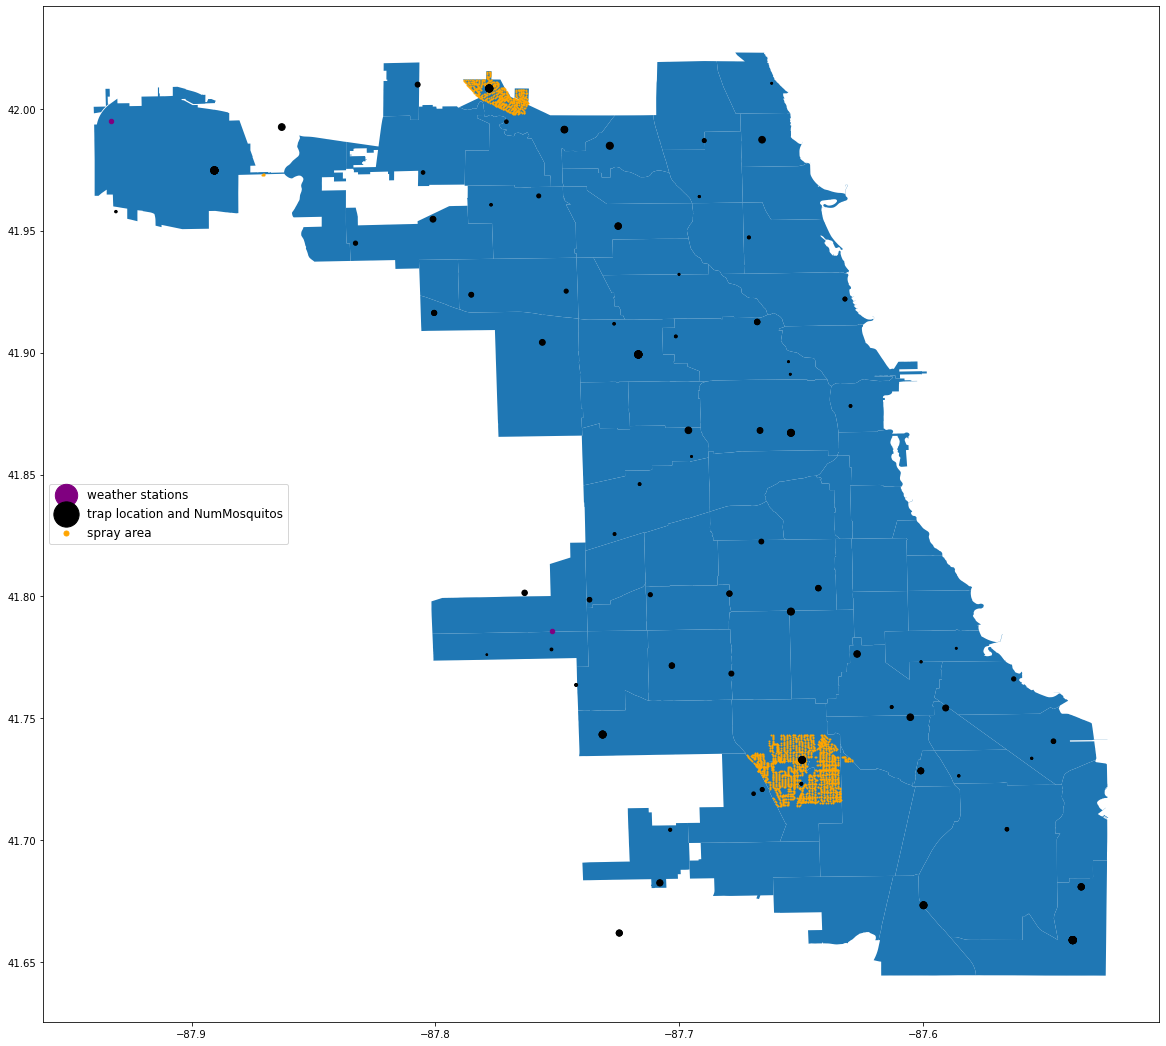

In [48]:
#mosquito numbers two week before spray
spray_date = pd.Timestamp(2013, 7,17 )
dict_df = {'trap location and NumMosquitos':df_train[ (df_train["Date"]  >= spray_date - datetime.timedelta(weeks = 2)) 
                                 & (df_train["Date"]  < spray_date) ], 
           'spray area':df_spray[ (df_spray["Date"]  == spray_date)],
          }
plot_geodata(dict_df)


#mosquito numbers two week after spray
dict_df = {'trap location and NumMosquitos':df_train[ (df_train["Date"]  >= spray_date ) 
                                 & (df_train["Date"]  < spray_date + datetime.timedelta(weeks = 2))], 
           'spray area':df_spray[ (df_spray["Date"]  == spray_date)],
          }
plot_geodata(dict_df)

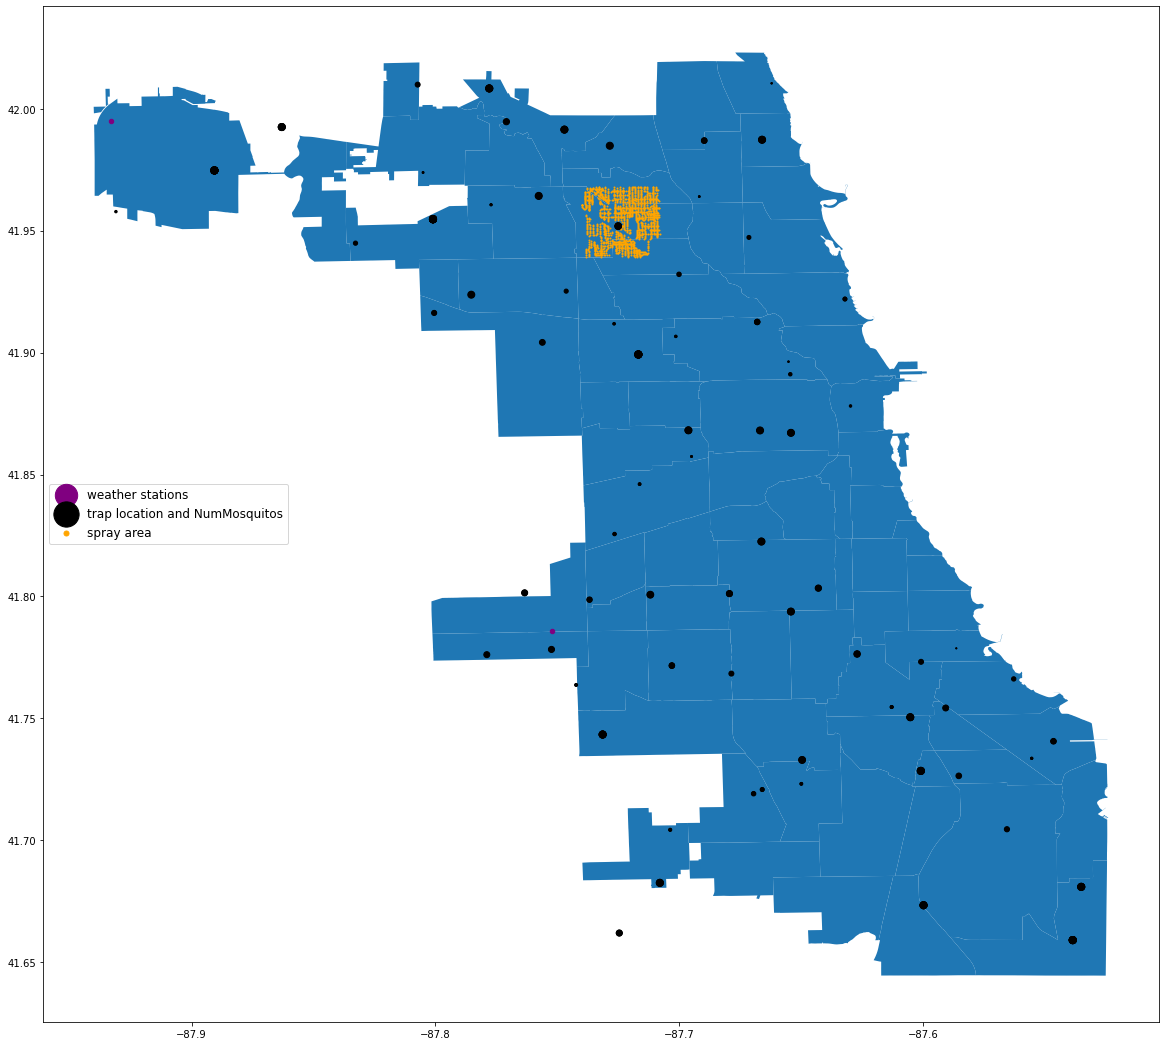

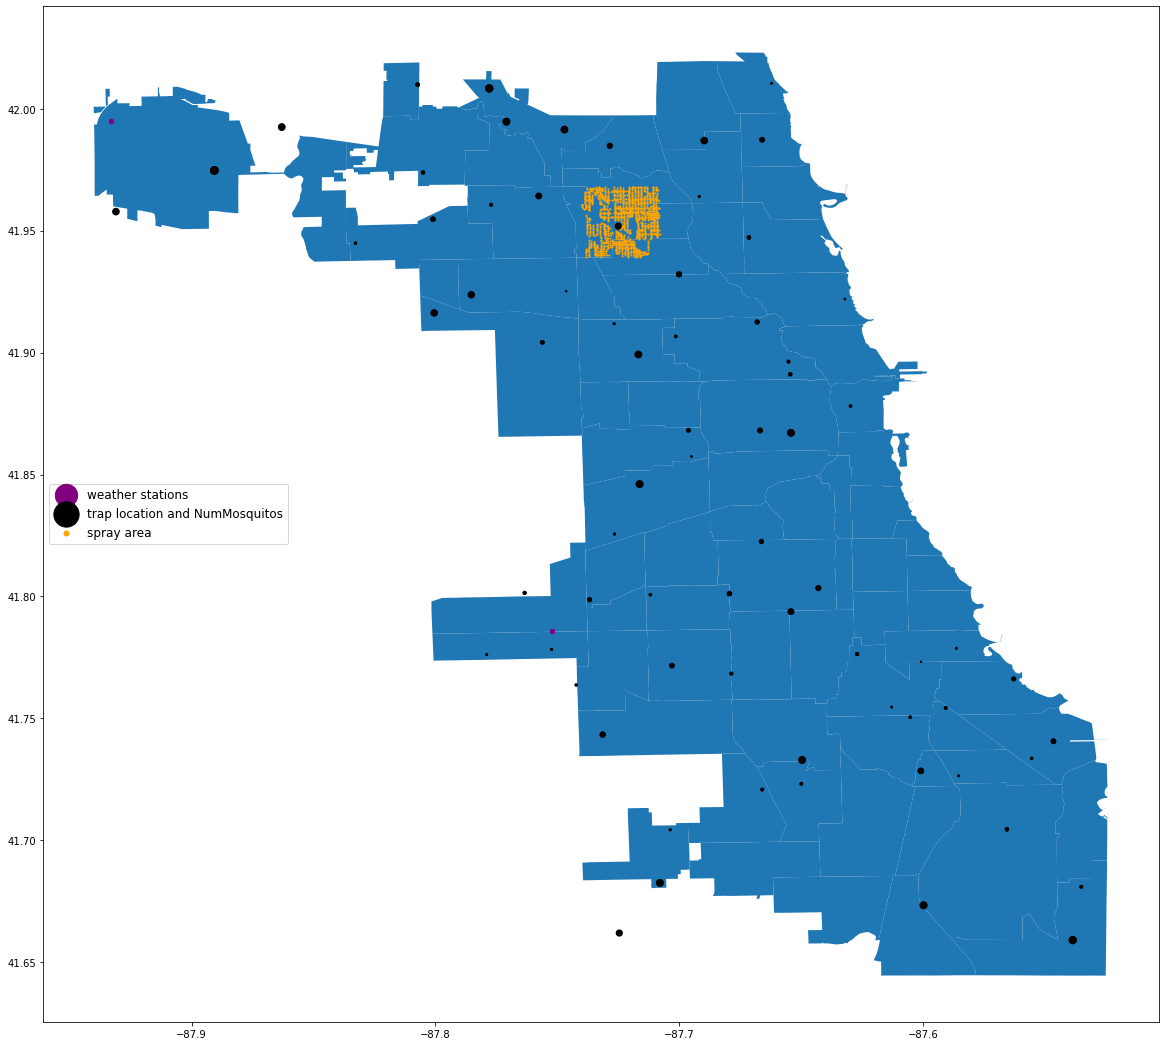

In [49]:
#mosquito numbers two week before spray
spray_date = pd.Timestamp(2013, 7,25 )
dict_df = {'trap location and NumMosquitos':df_train[ (df_train["Date"]  >= spray_date - datetime.timedelta(weeks = 2)) 
                                 & (df_train["Date"]  < spray_date) ], 
           'spray area':df_spray[ (df_spray["Date"]  == spray_date)],
          }
plot_geodata(dict_df)


#mosquito numbers two week after spray
dict_df = {'trap location and NumMosquitos':df_train[ (df_train["Date"]  >= spray_date ) 
                                 & (df_train["Date"]  < spray_date + datetime.timedelta(weeks = 2))], 
           'spray area':df_spray[ (df_spray["Date"]  == spray_date)],
          }
plot_geodata(dict_df)

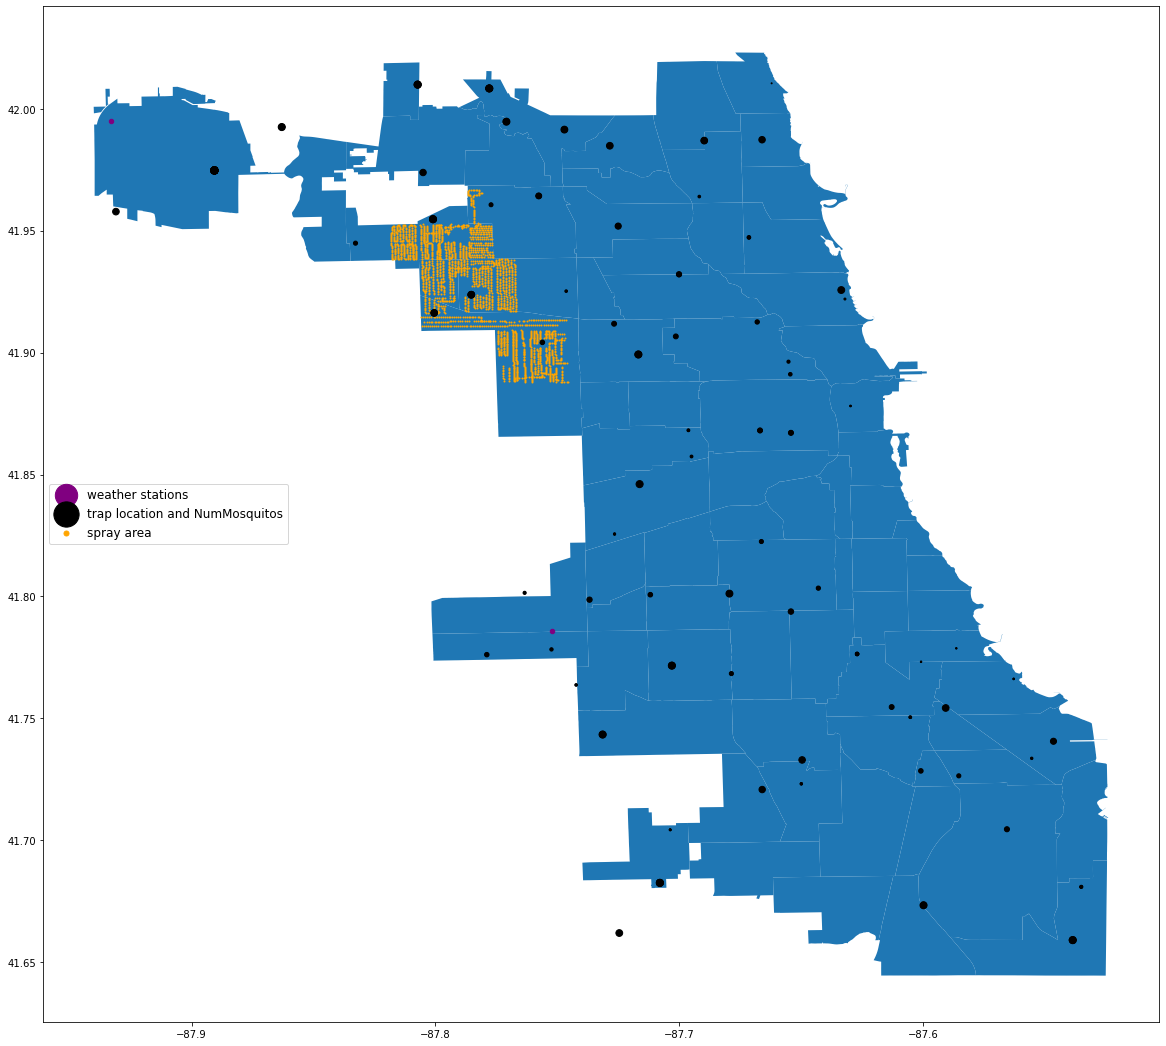

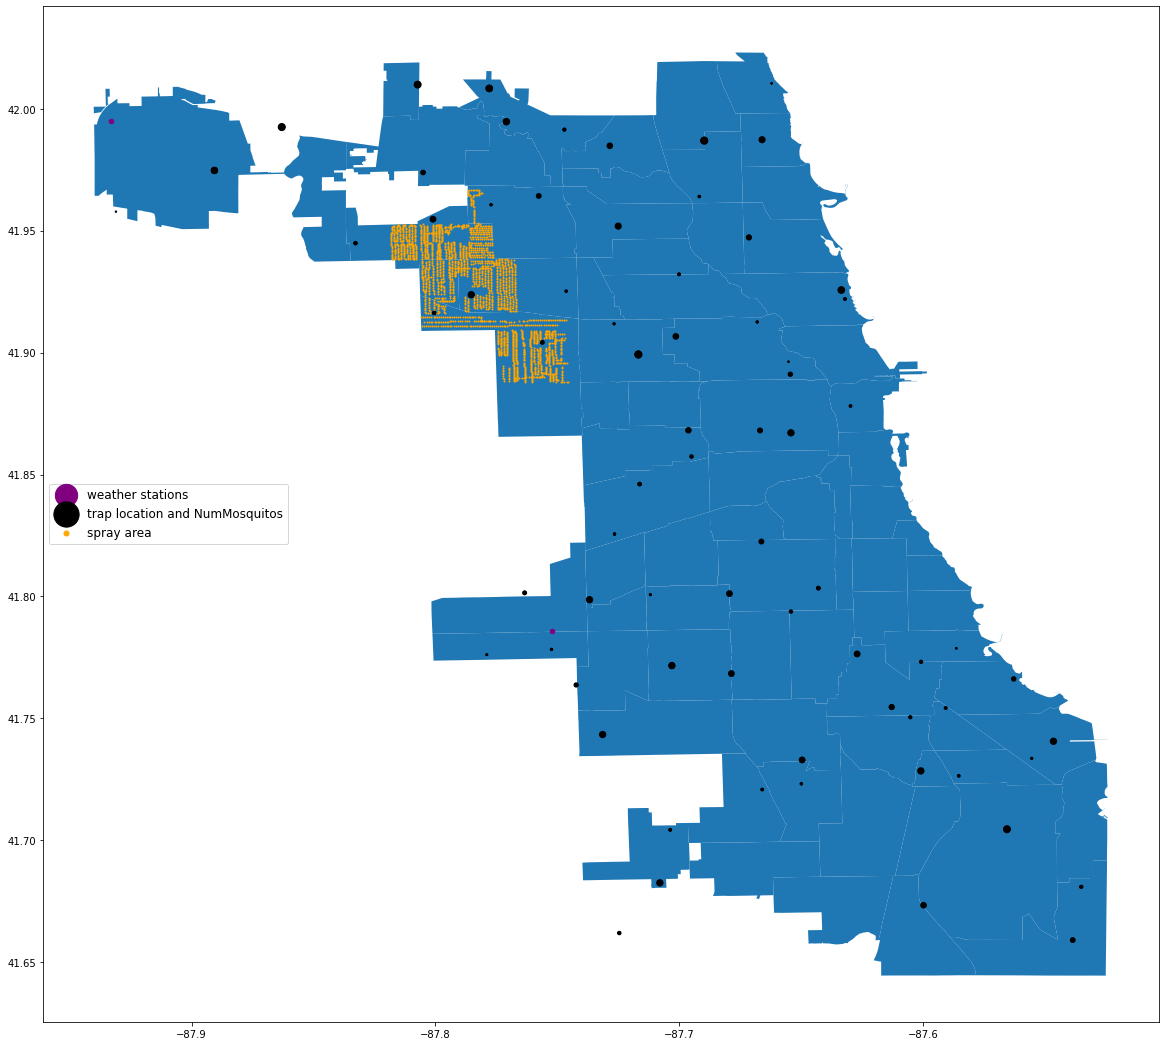

In [50]:
#mosquito numbers two week before spray
spray_date = pd.Timestamp(2013, 8,15 )
dict_df = {'trap location and NumMosquitos':df_train[ (df_train["Date"]  >= spray_date - datetime.timedelta(weeks = 2)) 
                                 & (df_train["Date"]  < spray_date) ], 
           'spray area':df_spray[ (df_spray["Date"]  == spray_date)],
          }
plot_geodata(dict_df)


#mosquito numbers two week after spray
dict_df = {'trap location and NumMosquitos':df_train[ (df_train["Date"]  >= spray_date ) 
                                 & (df_train["Date"]  < spray_date + datetime.timedelta(weeks = 2))], 
           'spray area':df_spray[ (df_spray["Date"]  == spray_date)],
          }
plot_geodata(dict_df)